In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")


In [2]:
data = pd.concat([train, test]).reset_index(drop=True)
data = data.drop(columns=["id"], axis=1)

# get numeric column names
num_cols = data._get_numeric_data().columns

# subract numeric columns from all columns to get categorical columns 
cat_cols = list(set(data.columns) - set(num_cols) - {'attack_cat'})

data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [15]:
# one hot encode categorical variables and concatenate them with the numerical variables
dummies_df = pd.concat([
    data[num_cols],
    pd.get_dummies(data['state']), 
    pd.get_dummies(data['service']), 
    pd.get_dummies(data['proto'])], 
    axis=1)

dummies_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,visa,vmtp,vrrp,wb-expak,wb-mon,wsn,xnet,xns-idp,xtp,zero
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0
257669,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,...,0,0,0,0,0,0,0,0,0,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# apply min-max scaler that scales the variables in the range [0-1]
scl = MinMaxScaler()
df = scl.fit_transform(dummies_df)

# apply principal component analysis
pca = PCA(n_components=0.95)
pca_df = pca.fit_transform(df)
pca_df.shape


(257673, 18)

164

AttributeError: 'Line2D' object has no property 'y'

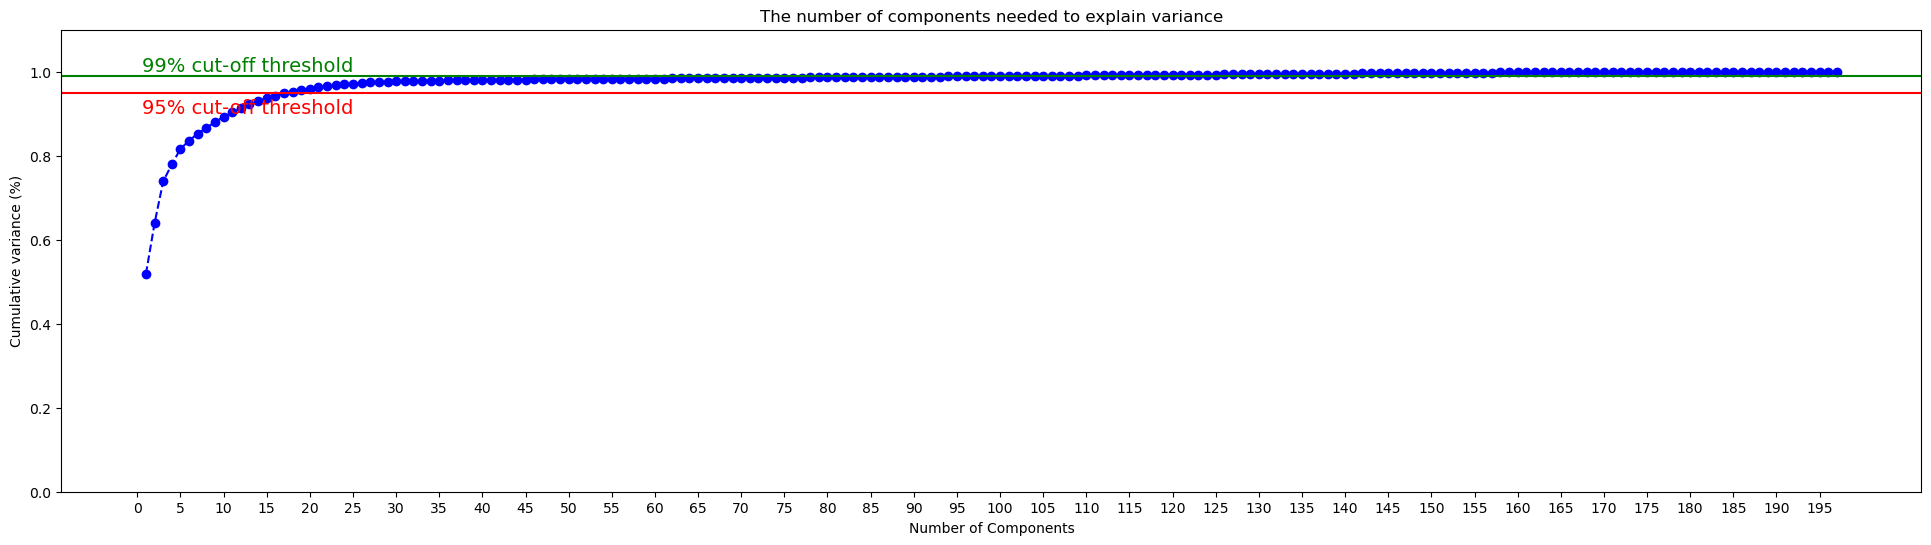

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def pca_analysis(df: pd.DataFrame, n_components: int):
    scl = MinMaxScaler()
    num_data = scl.fit_transform(df)

    pca = PCA().fit(num_data)

    fig, ax = plt.subplots()
    xi = np.arange(1, n_components+1, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.rcParams["figure.figsize"] = (24,6)

    plt.ylim(0.0, 1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, n_components+1, step=5))
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.9, '95% cut-off threshold', color='red', fontsize=14)

    plt.axhline(y=0.99, color='g', linestyle='-')
    plt.text(0.5, 1, '99% cut-off threshold', color='green', fontsize=14)

    plt.axvline(x=0.95, color='r', linestyle='-')
    # plt.text(0.5, 1, '99% cut-off threshold', color='green', fontsize=14)

    ax.grid(axis='x')
    plt.show()

pca_analysis(dummies_df, 197)

In [58]:
data[cat_cols]

,service,state,proto
0,-,INT,udp
1,-,INT,udp
2,-,INT,udp
3,-,INT,udp
4,-,INT,udp
...,...,...,...
257668,dns,INT,udp
257669,-,FIN,tcp
257670,dns,INT,udp
257671,dns,INT,udp


In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince

mca = prince.MCA(n_components=-1)
mca = mca.fit(data[cat_cols])

data[num_cols] = StandardScaler().fit_transform(data[num_cols])
pca = PCA(n_components=0.95)
pca = pca.fit_transform(data[num_cols])

print(mca.row_contributions_.shape, pca.shape)

(257673, 8) (257673, 21)


In [55]:
mca.scree_plot()

alt.Chart(...)

In [52]:
mca.plot_rows_columns()

AttributeError: 'MCA' object has no attribute 'plot_rows_columns'

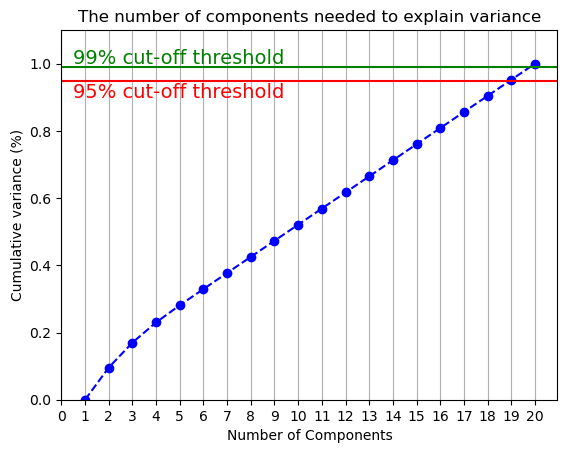

In [4]:
fig, ax = plt.subplots()
xi = np.arange(1, num_components+1, step=1)
y = mca.cumulative_percentage_of_variance_
y = (y-np.min(y))/(np.max(y)-np.min(y))

plt.rcParams["figure.figsize"] = (12,6)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_components+1, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color='red', fontsize=14)

plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 1, '99% cut-off threshold', color='green', fontsize=14)

ax.grid(axis='x')
plt.show()

In [5]:
df = pd.DataFrame([['red', 'NL'], ['blue', 'BE'], ['green', 'DE'], ['purple', 'DE']], columns=['color', 'nation'])

mca_test = prince.MCA(n_components=5)
mca_test = mca_test.fit(df)


In [6]:
dim_reduced = pd.DataFrame(np.concatenate((pca, mca.row_contributions_), axis=1))
dim_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-0.397809,-0.713293,-2.248982,0.952127,0.621503,-0.377912,0.053801,0.400166,-0.290617,0.146986,...,1.625270e-21,1.710442e-24,1.835655e-22,6.040837e-21,8.807517e-23,3.722140e-22,1.934386e-21,1.425960e-22,1.957489e-21,5.469441e-21
1,-0.647487,-0.949476,-2.507742,2.075608,1.125381,-1.126574,0.108503,1.091078,-0.462969,4.113590,...,1.633102e-21,1.558796e-24,1.883341e-22,6.055594e-21,8.733653e-23,3.758692e-22,1.937643e-21,1.402243e-22,1.960187e-21,5.470061e-21
2,-0.897510,-0.893496,-2.528292,1.731149,1.184814,-0.986919,0.185650,1.035444,-0.456727,3.413840,...,1.629084e-21,1.906882e-24,1.825258e-22,6.047405e-21,8.769841e-23,3.722554e-22,1.930005e-21,1.438570e-22,1.953216e-21,5.471849e-21
3,-0.828185,-0.785468,-2.318185,1.416573,0.928678,-0.752743,0.125306,0.785033,-0.392165,2.269999,...,1.629308e-21,1.691642e-24,1.848875e-22,6.045831e-21,8.686404e-23,3.732876e-22,1.928600e-21,1.438476e-22,1.958004e-21,5.476327e-21
4,-0.707173,-0.899497,-2.310802,2.156395,0.998206,-1.151770,0.045105,1.065487,-0.464376,4.390672,...,1.616924e-21,1.778005e-24,1.846952e-22,6.040170e-21,8.849418e-23,3.728272e-22,1.944235e-21,1.424442e-22,1.956393e-21,5.449672e-21


In [145]:
groups = {
    'state': ['state'],
    'service': ['service'],
    'proto': ['proto']
}

mfa = prince.MFA()
mfa = mfa.fit(data[cat_cols], groups=groups)
mfa
# prince.datasets.load_burgundy_wines()


c:\Users\janba\anaconda3\lib\site-packages\prince\mfa.py:59: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X = (X - X.mean()) / ((X - X.mean()) ** 2).sum() ** 0.5


ZeroDivisionError: float division by zero

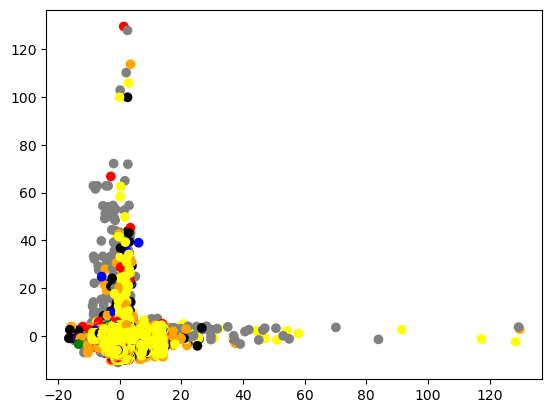

In [37]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

std_scl = StandardScaler()
num_data = std_scl.fit_transform(num_data)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(num_data)

pca_data = pca_data.reshape(((2, 257673)))

# pca_data = StandardScaler().fit_transform(pca_data)

colors = {
    'Normal': 'gray', 
    'Reconnaissance': 'red', 
    'Backdoor': 'green', 
    'DoS': 'blue', 
    'Exploits': 'orange',
    'Analysis': 'purple', 
    'Fuzzers': 'black', 
    'Worms': 'cyan', 
    'Shellcode': 'indigo', 
    'Generic': 'yellow'
}

plt.scatter(pca_data[0], pca_data[1], color=data['attack_cat'].map(colors))
plt.show()
